<a href="https://colab.research.google.com/github/trilgar/NN_2022/blob/master/NN_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from glob import glob
!pip install pytorch_lightning
from pytorch_lightning.utilities.types import EPOCH_OUTPUT
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import numpy as np
from torchvision import datasets
import pytorch_lightning as pl
from torch import nn
from pytorch_lightning.loggers import CSVLogger

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 20.8 MB/s 
     |████████████████████████████████| 529 kB 53.1 MB/s 
     |████████████████████████████████| 125 kB 74.2 MB/s 
     |████████████████████████████████| 87 kB 7.5 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=e833ece49645850c17911e612bd39046f4a8bcfe2d7569adf83b40e6d81ec8e6
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


Встановлення сіду генератору

In [2]:
torch.manual_seed(10)

In [3]:
EPOCHS = 2
accelerator='gpu'

Завантаження датасету OxfordIIITPet

In [4]:
training_data = datasets.OxfordIIITPet(
    root="A:/datasets",
    download=True,
)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting A:/datasets/oxford-iiit-pet/images.tar.gz to A:/datasets/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting A:/datasets/oxford-iiit-pet/annotations.tar.gz to A:/datasets/oxford-iiit-pet


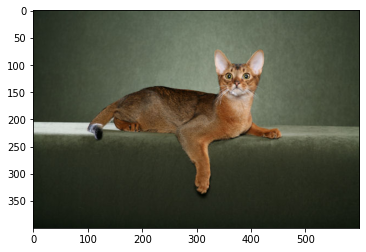

In [5]:
plt.imshow(plt.imread('A:/datasets/oxford-iiit-pet/images/Abyssinian_1.jpg'))

In [6]:
filenames = glob('A:/datasets/oxford-iiit-pet/images/*.jpg')

In [7]:
class PetDataSet(Dataset):

    def __init__(self, filenames, class_to_label, transforms=None):
        self.filenames = filenames
        self.transforms = transforms
        self.class_to_label = class_to_label

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        filename = self.filenames[i]
        # img = plt.imread(filename)
        # img = Image.fromarray(img).convert('RGB')
        img = Image.open(filename).convert('RGB')
        img = np.array(img).astype(np.uint8)

        if self.transforms is not None:
            img = self.transforms(img)
        label = self.get_label_from_filename(filename)
        return img, label

    def get_label_from_filename(self, filename):
        clazz = filename.rsplit('/', 1)[1].rsplit('_', 1)[0].replace('_', ' ').title()
        return self.class_to_label[clazz]

In [8]:
vgg_format = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [9]:
dataset = PetDataSet(filenames, training_data.class_to_idx, vgg_format)

train_ds_length = int(0.8 * len(dataset))
test_ds_length = int(0.2 * len(dataset))

train_ds, test_ds = torch.utils.data.random_split(dataset, [train_ds_length, test_ds_length])

train_dl = DataLoader(train_ds, batch_size=16)
test_dl = DataLoader(test_ds, batch_size=16)

Модель

In [10]:
model = torchvision.models.vgg19(pretrained=True)

number_of_labels = len(training_data.classes)
model.classifier = torch.nn.Sequential(
    model.classifier,
    torch.nn.Linear(in_features=1000, out_features=number_of_labels, bias=True)
)
model.features.requires_grad_(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [11]:
class Pytorch_Lightning_Classifier(pl.LightningModule):

    def __init__(self, model_):
        super().__init__()
        self.model = model_
        self.loss_func = nn.CrossEntropyLoss()
        self.epoch_accuracy = []
        self.accuracy = []
        self.epoch_loss = []
        self.loss = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss = self.loss_func(pred, y)
        self.log('train_loss', loss)
        self.epoch_loss.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=1)
        acc = torch.sum(labels == preds).item() / (len(labels) * 1.0)
        # By default logs it per epoch (weighted average over batches)
        self.epoch_accuracy.append(acc)
        self.log("val_acc", acc)

    def training_epoch_end(self, outputs: EPOCH_OUTPUT) -> None:
        super().training_epoch_end(outputs)
        self.loss.append(np.mean(self.epoch_loss))
        self.accuracy.append(np.mean(self.epoch_accuracy))
        self.epoch_loss.clear()
        self.epoch_accuracy.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        pred = self.forward(x)
        loss = self.loss_func(pred, y)
        pred = torch.argmax(pred, dim=1)
        accuracy = torch.sum(y == pred).item() / (len(y) * 1.0)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', torch.tensor(accuracy), prog_bar=True)
        output = dict({
            'test_loss': loss,
            'test_acc': torch.tensor(accuracy),
        })
        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

Навчання на повністю розміченому датасеті

In [12]:
fully_supervised_model = Pytorch_Lightning_Classifier(model)
trainer = pl.Trainer(accelerator=accelerator,
                     devices=1,
                     max_epochs=EPOCHS,
                     logger=CSVLogger(save_dir=f"logs/fully_supervised/"))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(fully_supervised_model, train_dl, val_dataloaders=test_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | VGG              | 143 M 
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
123 M     Trainable params
20.0 M    Non-trainable params
143 M     Total params
574.817   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [14]:
trainer.test(fully_supervised_model, test_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8640053868293762
        test_loss            0.407905250787735
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.407905250787735, 'test_acc': 0.8640053868293762}]

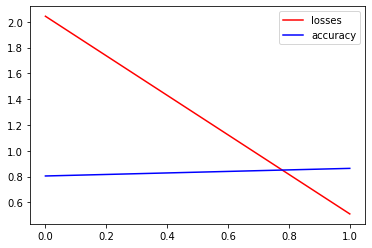

In [15]:
plt.plot(fully_supervised_model.loss, label='losses', color='red')
plt.plot(fully_supervised_model.accuracy, label='accuracy', color='blue')
plt.legend()
plt.show()

In [16]:
fully_supervised_model.accuracy

[0.8048245614035088, 0.8637992831541218]

Democratic co-training

In [17]:
model1 = torchvision.models.vgg19(pretrained=True)

model1.classifier = torch.nn.Sequential(
    model1.classifier,
    torch.nn.Linear(in_features=1000, out_features=number_of_labels, bias=True)
)

model2 = torchvision.models.alexnet(pretrained=True)
model2.classifier = torch.nn.Sequential(
    model2.classifier,
    torch.nn.Linear(in_features=1000, out_features=number_of_labels, bias=True)
)
model1.features.requires_grad_(False)
model2.features.requires_grad_(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [18]:
marked_ds_length = int(0.3 * len(train_ds))
unmarked_ds_length = int(0.7 * len(train_ds))
marked_ds, unmarked_ds = torch.utils.data.random_split(train_ds, [marked_ds_length + 1, unmarked_ds_length])
marked_dl = DataLoader(marked_ds, batch_size=8)
unmarked_dl = DataLoader(unmarked_ds, batch_size=8)

In [19]:
dct_model1 = Pytorch_Lightning_Classifier(model1)
dct_model2 = Pytorch_Lightning_Classifier(model2)

In [20]:
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     max_epochs=EPOCHS,
                     logger=CSVLogger(save_dir=f"logs/semisupervised_1/"))
trainer.fit(dct_model1, marked_dl, val_dataloaders=test_dl)
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     max_epochs=EPOCHS,
                     logger=CSVLogger(save_dir=f"logs/semisupervised_2/"))
trainer.fit(dct_model2, marked_dl, val_dataloaders=test_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | VGG              | 143 M 
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
123 M     Trainable params
20.0 M    Non-trainable params
143 M     Total params
574.817   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | AlexNet          | 61.1 M
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
58.7 M    Trainable params
2.5 M     Non-trainable params
61.1 M    Total params
244.552   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [21]:
partly_sup_acc = dct_model1.accuracy
partly_sup_loss = dct_model1.loss

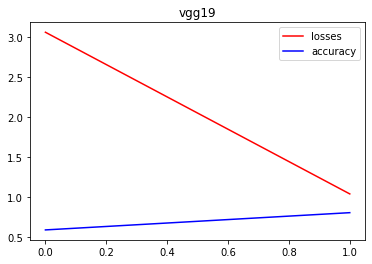

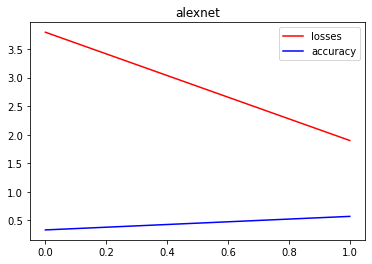

In [22]:
plt.title('vgg19')
plt.plot(dct_model1.loss, label='losses', color='red')
plt.plot(dct_model1.accuracy, label='accuracy', color='blue')
plt.legend()
plt.show()

plt.title('alexnet')
plt.plot(dct_model2.loss, label='losses', color='red')
plt.plot(dct_model2.accuracy, label='accuracy', color='blue')
plt.legend()
plt.show()

In [27]:
class DemocraticCotrainDataSet(Dataset):

    def __init__(self, marked_ds, unmarked_ds, class_to_label, transforms=None):
        self.marked_ds = marked_ds
        self.unmarked_ds = unmarked_ds
        self.transforms = transforms
        self.class_to_label = class_to_label

    @staticmethod
    def from_ss(marked: Subset, unmarked: Subset, transforms=None):
        return DemocraticCotrainDataSet(marked, unmarked, class_to_label = marked.dataset.dataset.class_to_label, transforms = transforms)

    def __len__(self):
        return len(self.unmarked_ds)

    def __getitem__(self, i):
        unmarked, _ = self.unmarked_ds[i]
        marked, label = self.marked_ds[i % len(self.marked_ds)]
        return unmarked, marked, label

    def get_label_from_filename(self, filename):
        clazz = filename.rsplit('/', 1)[1].rsplit('_', 1)[0].replace('_', ' ').title()
        return self.class_to_label[clazz]

In [28]:
class Democratic_CO_Trainer(pl.LightningModule):

    def __init__(self, m1: Pytorch_Lightning_Classifier, m2: Pytorch_Lightning_Classifier):
        super().__init__()
        self.model1 = m1
        self.model2 = m2
        self.loss_func = nn.CrossEntropyLoss()

        self.epoch_accuracy = []
        self.accuracy = []

        self.epoch_loss1 = []
        self.loss1 = []

        self.epoch_loss2 = []
        self.loss2 = []

    def forward(self, x):
        return [self.model1(x), self.model2(x)]

    def training_step(self, batch, batch_idx):
        unmarked_x, marked_x, label = batch
        u_pred1, u_pred2 = self.forward(unmarked_x)
        m_pred1, m_pred2 = self.forward(marked_x)
        loss1 = self.loss_func(u_pred1, u_pred2.argmax(dim=1)) + self.loss_func(m_pred1, label)
        loss2 = self.loss_func(u_pred2, u_pred1.argmax(dim=1)) + self.loss_func(m_pred2, label)
        self.log('train_loss1', loss1)
        self.log('train_loss2', loss2)
        self.epoch_loss1.append(loss1.item())
        self.epoch_loss2.append(loss2.item())
        return (loss1 + loss2) / 2.0

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds1 = self.model1(imgs)
        preds2 = self.model2(imgs)
        preds = (preds1 + preds2).argmax(dim=1)
        acc = torch.sum(labels == preds).item() / (len(labels) * 1.0)
        # By default logs it per epoch (weighted average over batches)
        self.epoch_accuracy.append(acc)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        pred1, pred2 = self.forward(x)
        pred = (pred1 + pred2) / 2
        loss = self.loss_func(pred, y)
        pred = torch.argmax(pred, dim=1)
        accuracy = torch.sum(y == pred).item() / (len(y) * 1.0)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', torch.tensor(accuracy), prog_bar=True)
        output = dict({
            'test_loss': loss,
            'test_acc': torch.tensor(accuracy),
        })
        return output

    def training_epoch_end(self, outputs: EPOCH_OUTPUT) -> None:
        super().training_epoch_end(outputs)
        self.loss1.append(np.mean(self.epoch_loss1))
        self.epoch_loss1.clear()
        self.loss2.append(np.mean(self.epoch_loss2))
        self.epoch_loss2.clear()
        self.accuracy.append(np.mean(self.epoch_accuracy))
        self.epoch_accuracy.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5)
        return optimizer


In [29]:
democratic_train_ds = DemocraticCotrainDataSet.from_ss(marked_ds, unmarked_ds, transforms=vgg_format)


In [30]:
democtatic_cotrain_model = Democratic_CO_Trainer(dct_model1, dct_model2)
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     max_epochs=EPOCHS,
                     logger=CSVLogger(save_dir=f"logs/democratic_cotrainer/"))
trainer.fit(democtatic_cotrain_model, DataLoader(democratic_train_ds, batch_size=8), val_dataloaders=test_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                         | Params
-----------------------------------------------------------
0 | model1    | Pytorch_Lightning_Classifier | 143 M 
1 | model2    | Pytorch_Lightning_Classifier | 61.1 M
2 | loss_func | CrossEntropyLoss             | 0     
-----------------------------------------------------------
182 M     Trainable params
22.5 M    Non-trainable params
204 M     Total params
819.369   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


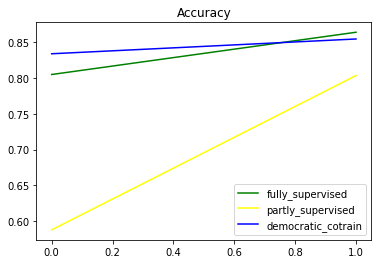

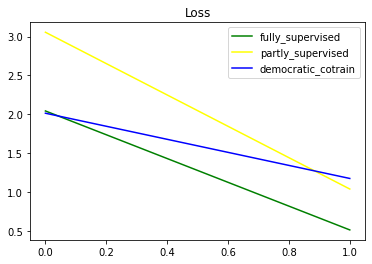

In [31]:
plt.title('Accuracy')
plt.plot(fully_supervised_model.accuracy, label='fully_supervised', color='green')
plt.plot(partly_sup_acc, label='partly_supervised', color='yellow')
plt.plot(democtatic_cotrain_model.accuracy, label='democratic_cotrain', color='blue')
plt.legend()
plt.show()

plt.title('Loss')
plt.plot(fully_supervised_model.loss, label='fully_supervised', color='green')
plt.plot(partly_sup_loss, label='partly_supervised', color='yellow')
plt.plot(democtatic_cotrain_model.loss1, label='democratic_cotrain', color='blue')
plt.legend()
plt.show()